In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import model.explainn as explainn
import feature.simulated_dataset as simulated_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import plot.plot_motifs as plot_motifs
import analysis.motif_util as motif_util
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import logomaker

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
mechint_model_path = os.path.join(base_path, "models/trained_models/simulated/rest_exp_both_v2/mechint_net/1/last_ckpt.pth")
explainn_model_path = os.path.join(base_path, "models/trained_models/simulated/rest_exp_both_v2/explainn/1/last_ckpt.pth")

In [6]:
motif_config_path = os.path.join(base_path, "data/simulations/configs/rest_exp_both_v2_config.json")
neg_motif_config_path = os.path.join(base_path, "data/simulations/configs/rest_exp_both_v2_neg_config.json")

In [7]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/mechint_vs_explainn_expressivity"
os.makedirs(figures_out_path, exist_ok=True)

### Import models and create data loader

In [8]:
mechint_model = model_util.load_model(
    mechint_net.MechIntRegNet, mechint_model_path
).to(DEVICE)

explainn_model = model_util.load_model(
    explainn.ExplaiNN, explainn_model_path
).to(DEVICE)

In [9]:
data_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 128,
        "num_batches": 10,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x1514175f7440>
INFO - sim_dataset - Completed after 0:00:00


### Run predictions

In [10]:
_, _, mechint_model_outputs, _, _, mechint_input_data = \
    train_model.run_epoch(data_loader, "eval", mechint_model, epoch_num=0, return_extras=True)
_, _, explainn_model_outputs, _, _, explainn_input_data = \
    train_model.run_epoch(data_loader, "eval", explainn_model, epoch_num=0, return_extras=True)

	Loss: 0.5536: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


In [11]:
mechint_true_labels, mechint_pred_probs = np.squeeze(mechint_input_data[1], axis=1), np.squeeze(mechint_model_outputs, axis=1)
explainn_true_labels, explainn_pred_probs = np.squeeze(explainn_input_data[1], axis=1), np.squeeze(explainn_model_outputs, axis=1)

### Compute performance metrics

In [12]:
mechint_metrics = performance.compute_performance_metrics(mechint_true_labels, mechint_pred_probs)
explainn_metrics = performance.compute_performance_metrics(explainn_true_labels, explainn_pred_probs)

for name, metrics in (("ARGMINN", mechint_metrics), ("ExplaiNN", explainn_metrics)):
    print(name)
    max_key_len = max(len(k) for k in metrics.keys())
    for key, val in metrics.items():
        print("%s: %6.4f" % (key.ljust(max_key_len), val))
    print()

ARGMINN
acc    : 0.9016
pos_acc: 0.8609
neg_acc: 0.9422
auroc  : 0.9538
precis : 0.9371
recall : 0.8609
auprc  : 0.9598

ExplaiNN
acc    : 0.7273
pos_acc: 0.7219
neg_acc: 0.7328
auroc  : 0.7809
precis : 0.7299
recall : 0.7219
auprc  : 0.7598



### Extract motifs

In [13]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [14]:
mechint_pfms = model_to_pfms(mechint_model, data_loader)
explainn_pfms = model_to_pfms(explainn_model, data_loader)

/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.5446: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


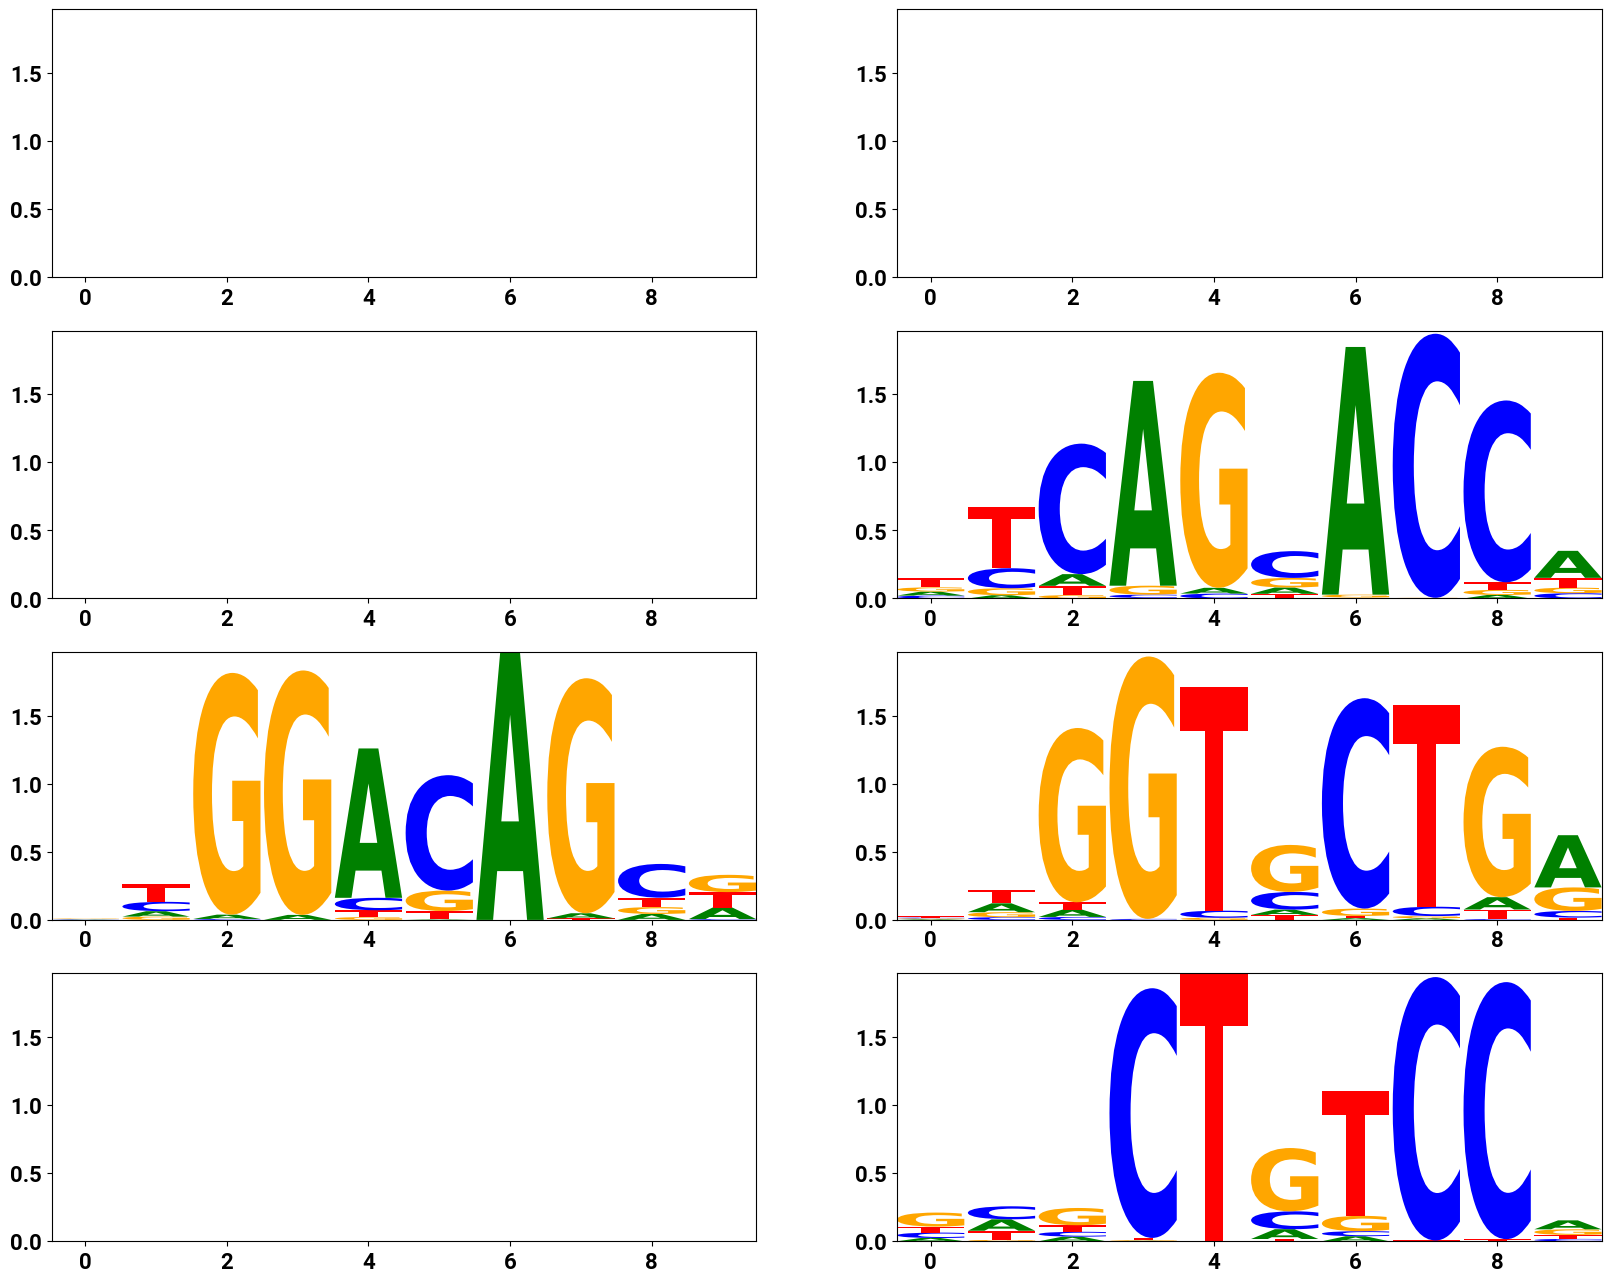

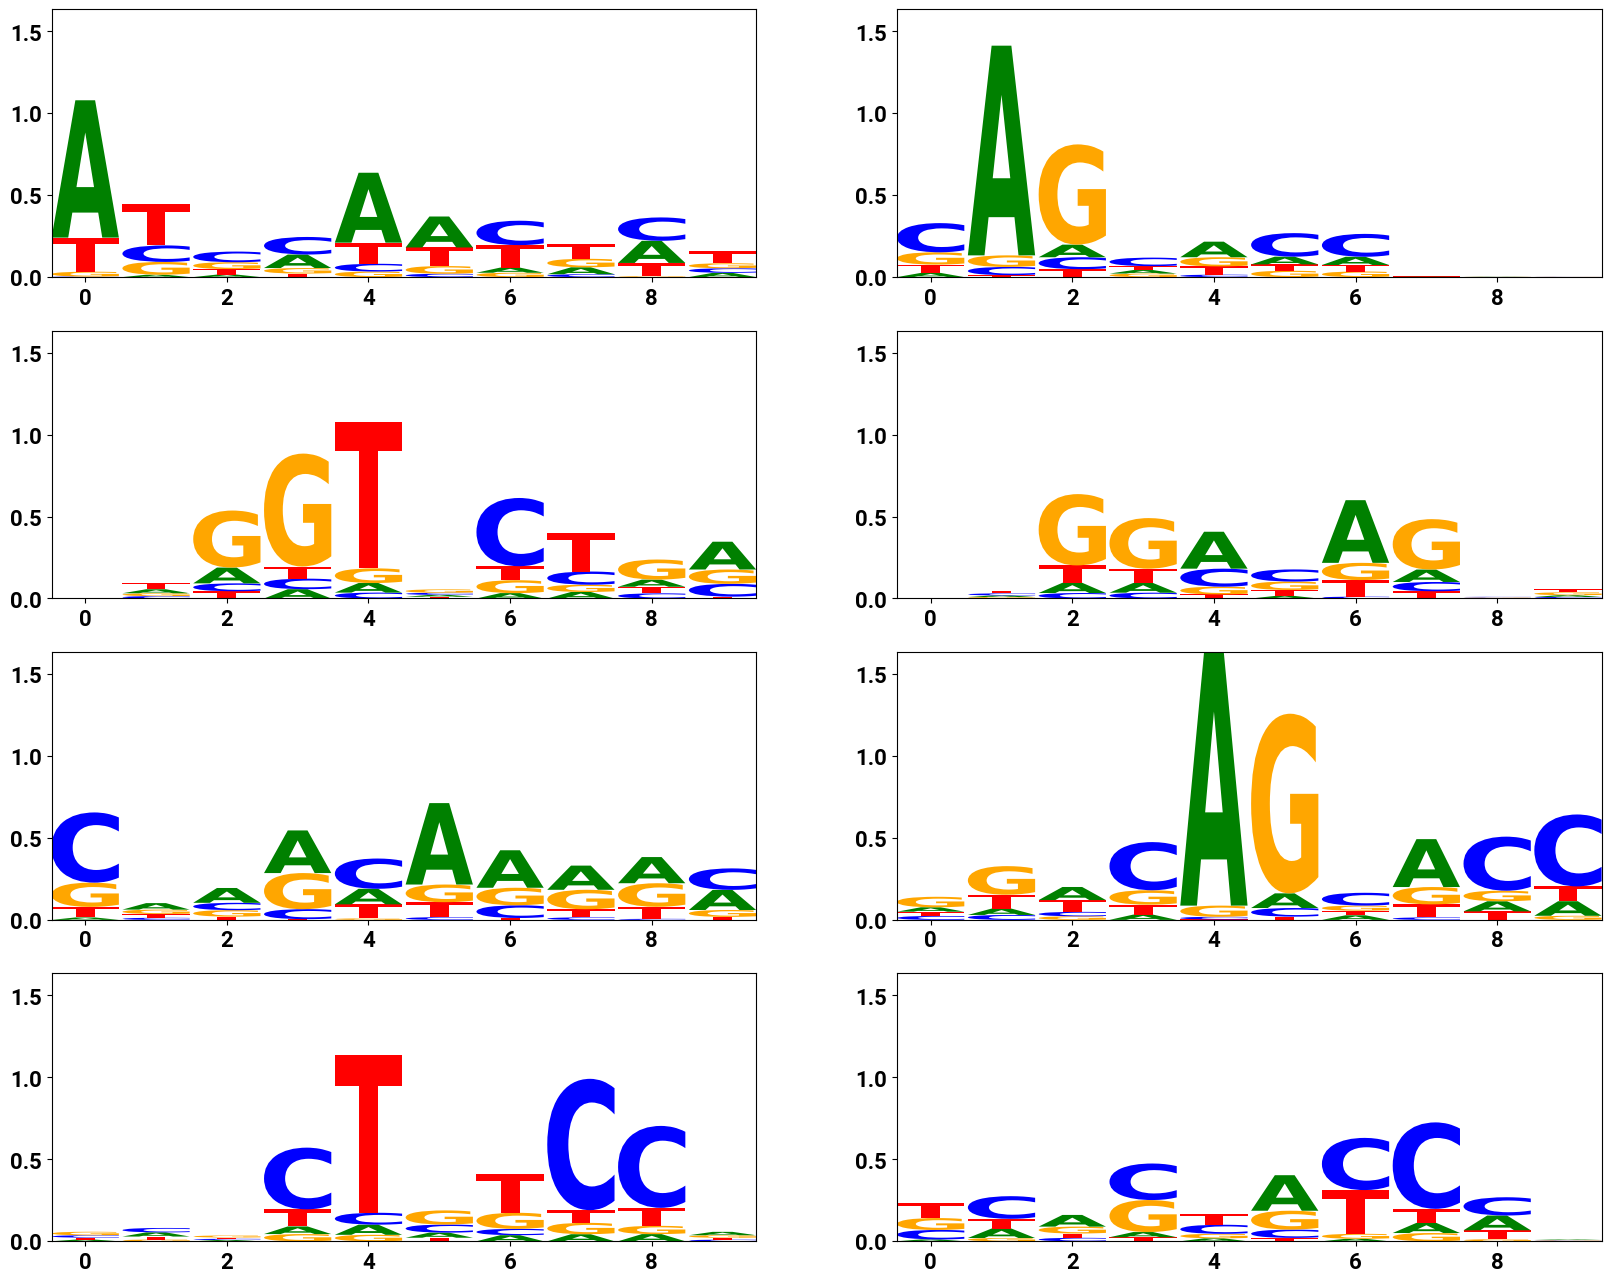

In [16]:
fig = plot_motifs.plot_motif_grid([pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in mechint_pfms])
fig.savefig(os.path.join(figures_out_path, "mechint_filter_motifs.svg"), format="svg")
fig = plot_motifs.plot_motif_grid([pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in explainn_pfms])
fig.savefig(os.path.join(figures_out_path, "explainn_filter_motifs.svg"), format="svg")
plt.show()